The data used in this project analysis is download from Yahoo Finance for company Webster Financial Corporation (WBS)and Independent Bank Corp. (INDB). INDB is the largest competitor of Webster Bank. 

In [136]:
!pip install pandas-profiling

In [137]:
import pandas as pd
import numpy as np
import pandas_profiling

In [138]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_80bafe65c67442b9ab2c5f057cd5c54f = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='lhYSDtMh8oiZaEwtK--7QkqCopQoOyFLUl0ovsJfcGck',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_80bafe65c67442b9ab2c5f057cd5c54f.get_object(Bucket='mlforfinance-donotdelete-pr-2bhdpj3vjhx25t',Key='WBS.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
WBS_df = pd.read_csv(body)

In [139]:
WBS_df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,7/10/2019,46.720001,46.990002,45.830002,45.910000,45.910000,385700
1,7/9/2019,45.950001,46.580002,45.810001,46.560001,46.560001,394100
2,7/8/2019,46.950001,47.259998,46.200001,46.400002,46.400002,311200
3,7/5/2019,47.169998,47.860001,47.040001,47.419998,47.419998,206000
4,7/3/2019,46.299999,46.990002,46.220001,46.889999,46.889999,242400


In [140]:
pandas_profiling.ProfileReport(WBS_df)

In [6]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(*args, **kw)>

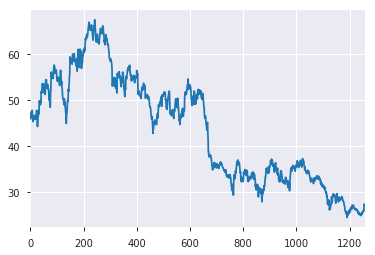

In [7]:
WBS_df['Adj_Close'].plot()
plt.show

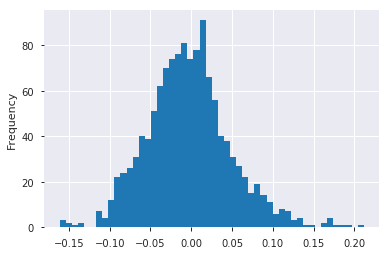

In [8]:
WBS_df['10d_close_pct']=WBS_df['Adj_Close'].pct_change(10)

WBS_df['10d_close_pct'].plot.hist(bins=50)
plt.show()

## Correlations
Correlations are nice to check out before building machine learning models, because we can see which features correlate to the target most strongly. Pearson's correlation coefficient is often used, which only detects linear relationships. It's commonly assumed our data is normally distributed, which we can "eyeball" from histograms. Highly correlated variables have a Pearson correlation coefficient near 1 (positively correlated) or -1 (negatively correlated). A value near 0 means the two variables are not linearly correlated.

If we use the same time periods for previous price changes and future price changes, we can see if the stock price is mean-reverting (bounces around) or trend-following (goes up if it has been going up recently).

In [9]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
WBS_df['5d_future_close'] = WBS_df['Adj_Close'].shift(-5)
WBS_df['5d_close_future_pct'] = WBS_df['5d_future_close'].pct_change(5)
WBS_df['5d_close_pct'] = WBS_df['Adj_Close'].pct_change(5)

In [10]:
# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = WBS_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)


                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.000617
5d_close_future_pct     -0.000617             1.000000


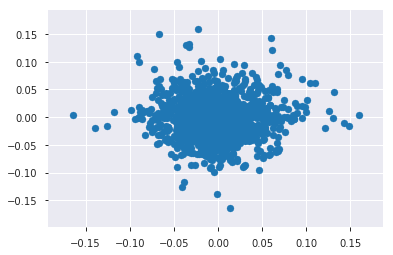

In [11]:
# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(WBS_df['5d_close_pct'], WBS_df['5d_close_future_pct'])
plt.show()

## Data transforms, features, and targets

### Making features and targets


**Create features and targets**

We almost have features and targets that are machine-learning ready -- we have features from current price changes (5d_close_pct) and indicators (moving averages and RSI), and we created targets of future price changes (5d_close_future_pct). Now we need to break these up into separate numpy arrays so we can feed them into machine learning algorithms.

Our indicators also cause us to have missing values at the beginning of the DataFrame due to the calculations. We could backfill this data, fill it with a single value, or drop the rows. Dropping the rows is a good choice, so our machine learning algorithms aren't confused by any sort of backfilled or 0-filled data. Pandas has a .dropna() function which we will use to drop any rows with missing values.

In [12]:
# Drop all na values
WBS_df = WBS_df.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
feature_names = ['5d_close_pct']
features = WBS_df[feature_names]
targets = WBS_df['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = WBS_df[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     5d_close_future_pct  5d_close_pct
5d_close_future_pct             1.000000      0.000101
5d_close_pct                    0.000101      1.000000


**Check the correlations**

Before we fit our first machine learning model, let's look at the correlations between features and targets. Ideally we want large (near 1 or -1) correlations between features and targets. Examining correlations can help us tweak features to maximize correlation (for example, altering the timeperiod argument in the talib functions). It can also help us remove features that aren't correlated to the target.

To easily plot a correlation matrix, we can use seaborn's heatmap() function. This takes a correlation matrix as the first argument, and has many other options. Check out the annot option -- this will help us turn on annotations.

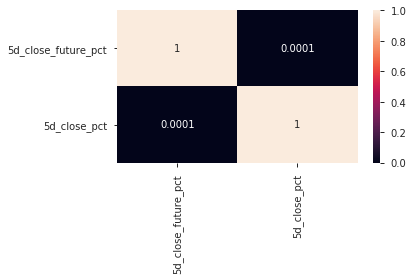

<Figure size 432x288 with 0 Axes>

In [13]:
import seaborn as sns
# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

## Linear Modeling with Financial data

In [14]:
# Make train and test sets

import statsmodels.api as sm

linear_features=sm.add_constant(features)

train_size=int(0.05*targets.shape[0])

train_features=linear_features[:train_size]
train_targets= targets[:train_size]

test_features= linear_features[train_size:]
test_targets= targets[train_size:]

/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [18]:
### Linear modeling

model =sm.OLS(train_targets, train_features)
results=model.fit()

In [19]:
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.014
Model:                             OLS   Adj. R-squared:                 -0.003
Method:                  Least Squares   F-statistic:                    0.8474
Date:                 Thu, 11 Jul 2019   Prob (F-statistic):              0.361
Time:                         23:50:45   Log-Likelihood:                 119.46
No. Observations:                   62   AIC:                            -234.9
Df Residuals:                       60   BIC:                            -230.7
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0083      0.005    

In [20]:
# P-values

print(results.pvalues)

const           0.081766
5d_close_pct    0.360980
dtype: float64


Pvalue less 0.05 is significant different

**Create train and test features**

Before we fit our linear model, we want to add a constant to our features, so we have an intercept for our linear model.

We also want to create train and test features. This is so we can fit our model to the train dataset, and evaluate performance on the test dataset. We always want to check performance on data the model has not seen to make sure we're not overfitting, which is memorizing patterns in the training data too exactly.

With a time series like this, we typically want to use the oldest data as our training set, and the newest data as our test set. This is so we can evaluate the performance of the model on the most recent data, which will more realistically simulate predictions on data we haven't seen yet.

In [121]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(1244, 2) (1057, 2) (187, 2)


/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


**Fit a linear model**

We'll now fit a linear model, because they are simple and easy to understand. Once we've fit our model, we can see which predictor variables appear to be meaningfully linearly correlated with the target, as well as their magnitude of effect on the target. Our judgment of whether or not predictors are significant is based on the p-values of coefficients. This is using a t-test to statistically test if the coefficient significantly differs from 0. The p-value is the percent chance that the coefficient for a feature does not differ from zero. Typically, we take a p-value of less than 0.05 to mean the coefficient is significantly different from 0.

In [24]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.001
Method:                  Least Squares   F-statistic:                    0.2257
Date:                 Thu, 11 Jul 2019   Prob (F-statistic):              0.635
Time:                         23:59:51   Log-Likelihood:                 1972.2
No. Observations:                 1057   AIC:                            -3940.
Df Residuals:                     1055   BIC:                            -3930.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0009      0.001    

**Evaluate our results**

Once we have our linear fit and predictions, we want to see how good the predictions are so we can decide if our model is any good or not. Ideally, we want to back-test any type of trading strategy. However, this is a complex and typically time-consuming experience.

A quicker way to understand the performance of our model is looking at regression evaluation metrics like R2, and plotting the predictions versus the actual values of the targets. Perfect predictions would form a straight, diagonal line in such a plot, making it easy for us to eyeball how our predictions are doing in different regions of price changes. We can use matplotlib's .scatter() function to create scatter plots of the predictions and actual values.

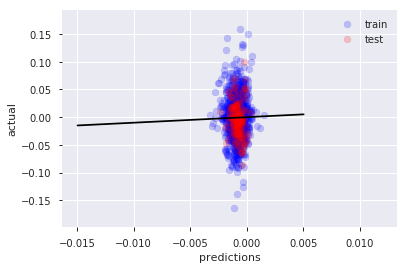

In [25]:
# Scatter the predictions vs the targets with 80% transparency
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha= 0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

## One problem with linear models

Some models that don't require manually creating interaction features:

* Decision-tree-based models

* Random forests

* Gradient boosting
* Others

### Feature engineering from volume

We're going to use non-linear models to make more accurate predictions. With linear models, features must be linearly correlated to the target. Other machine learning models can combine features in non-linear ways. For example, what if the price goes up when the moving average of price is going up, and the moving average of volume is going down? The only way to capture those interactions is to either multiply the features, or to use a machine learning algorithm that can handle non-linearity (e.g. random forests).

To incorporate more information that may interact with other features, we can add in weakly-correlated features. First we will add volume data, which we have in the lng_df as the Volume column.

In [35]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Volume_1d_change', 'Volume_1d_change_SMA']
feature_names.extend(new_features)
WBS_df['Volume_1d_change'] = WBS_df['Volume'].pct_change()


In [ ]:
WBS_df['Volume_1d_change_SMA'] = talib.SMA(lng_df['Volume_1d_change'].values,timeperiod=5)

## Decision Trees

### Decision Tree Splits

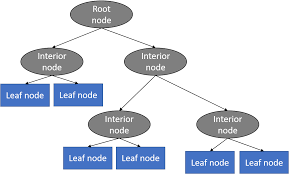

## Fit a decision tree

Random forests are a go-to model for predictions; they work well out of the box. But we'll first learn the building block of random forests -- decision trees.

Decision trees split the data into groups based on the features. Decision trees start with a root node, and split the data down until we reach leaf nodes.

We can use sklearn to fit a decision tree with DecisionTreeRegressor and .fit(features, targets).

Without limiting the tree's depth (or height), it will keep splitting the data until each leaf has 1 sample in it, which is the epitome of overfitting. We'll learn more about overfitting in the coming chapters.

In [42]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

0.9997386150510512
-2.120549970287085


**Try different max depths**

We always want to optimize our machine learning models to make the best predictions possible. We can do this by tuning hyperparameters, which are settings for our models. We will see in more detail how these are useful in future chapters, but for now think of them as knobs we can turn to tune our predictions to be as good as possible.

For regular decision trees, probably the most important hyperparameter is max_depth. This limits the number of splits in a decision tree. Let's find the best value of max_depth based on the R2 score of our model on the test set, which we can obtain using the score() method of our decision tree models.

In [43]:
# Loop through a few different max depths and check the performance
for d in [3, 5, 10]: #Loop through the values 3, 5, and 10 for use as the max_depth parameter in our decision tree model.
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d)) # Set the max_depth parameter in our DecisionTreeRegressor to be equal to d in each loop iteration.
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 3
0.053328730794646284
-0.07430335145568567 

max_depth= 5
0.11511476682377231
-0.19548430360397528 

max_depth= 10
0.3658963752423394
-0.8287659139358506 



** Check our results**

Once we have an optimized model, we want to check how it is performing in more detail. We already saw the R2 score, but it can be helpful to see the predictions plotted vs actual values. We can use the .predict() method of our decision tree model to get predictions on the train and test sets.

Ideally, we want to see diagonal lines from the lower left to the upper right. However, due to the simplicity of decisions trees, our model is not going to do well on the test set. But it will do well on the train set.

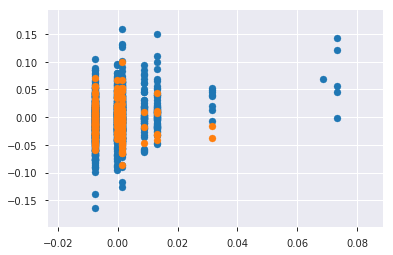

In [44]:
# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.show()

## Random Forests

### Feature sampling
Random Forests

* A collection (ensemble) of decision trees
* Bootstrap aggregating (bagging)
* Sample of features at each split

### Fit a random forest
Data scientists often use random forest models. They perform well out of the box, and have lots of settings to optimize performance. Random forests can be used for classification or regression; we'll use it for regression to predict the future price change of WBS.

We'll create and fit the random forest model similarly to the decision trees using the .fit(features, targets) method. With sklearn's RandomForestRegressor, there's a built-in .score() method we can use to evaluate performance. This takes arguments (features, targets), and returns the R2 score (the coefficient of determination).

In [105]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features,test_targets))

0.80577318722575
-1.1011039118591377


In [107]:
# obtain predictions from the test data 
predicted_rf = rfr.predict(test_features)

**Tune random forest hyperparameters**

As with all models, we want to optimize performance by tuning hyperparameters超参数. We have many hyperparameters for random forests, but the most important is often the number of features we sample at each split, or max_features in RandomForestRegressor from the sklearn library. For models like random forests that have randomness built-in, we also want to set the random_state. This is set for our results to be reproducible.

Usually, we can use sklearn's GridSearchCV() method to search hyperparameters, but **with a financial time series, we don't want to do cross-validation due to data mixing. We want to fit our models on the oldest data and evaluate on the newest data.** So we'll use sklearn's ParameterGrid to create combinations of hyperparameters to search.

In [85]:
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
#Set the n_estimators hyperparameter to be a list with one value (200) in the grid dictionary
# Set the max_features hyperparameter to be a list containing 4 and 8 in the grid dictionary.
grid = {'n_estimators': [200], 
        'max_depth' : [3],
        'max_features' : ['auto', 'sqrt'], 
        'random_state' : [42]
       }
test_scores = [] 


In [80]:
# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

In [81]:
# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-0.0661070472906411 {'random_state': 42, 'n_estimators': 200, 'max_features': 'auto', 'max_depth': 3}


## Evaluate performance

Lastly, and as always, we want to evaluate performance of our best model to check how well or poorly we are doing. Ideally it's best to do back-testing, but that's an involved process we don't have room to cover in this course.

We've already seen the R2 scores, but let's take a look at the scatter plot of predictions vs actual results using matplotlib. Perfect predictions would be a diagonal line from the lower left to the upper right.

In [129]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score

In [ ]:
# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

### Extracting feature importances 功能重要性和梯度提升

In [132]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor()
random_forest.fit(train_features, train_targets)

feature_importances = random_forest.feature_importances_

print(feature_importances)

[0. 1.]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Sorting and plotting

In [133]:
# feature importances from random forest model
importances = random_forest.feature_importances_

# index of greatest to least feature importances
sorted_index = np.argsort(importances)[::-1]

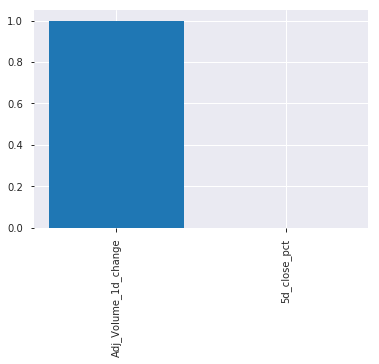

In [134]:
x = range(len(importances))
# create tick labels
labels = np.array(feature_names)[sorted_index]

plt.bar(x, importances[sorted_index], tick_label=labels)

# rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()